## Load libraries

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
import keras.models
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,Conv2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


In [0]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras import optimizers

In [0]:
save_model_name = "/content/gdrive/My Drive/connecting dots/saved_models/session_11_model_kbr_2.h5"
best_weights_name = "/content/gdrive/My Drive/connecting dots/saved_models/session_11_weights_kbr_2.h5"


In [0]:
from google.colab import drive


In [5]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os

In [7]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 3s 0us/step


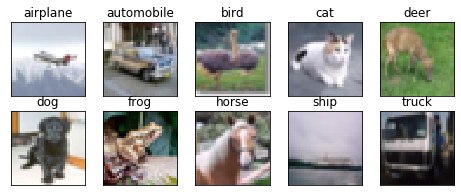

In [8]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Model history

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(trainX)
iterator = datagen.flow(trainX, trainy, batch_size=128)
batchX, batchy = iterator.next()
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)
batchX, batchy = iterator.next()

In [0]:
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()
X_train = batchX
X_test = batch_testX
y_train=batchy
y_test=batch_testy

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

## Cutout

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

## LR Finder

In [0]:
from keras.callbacks import Callback
import os
import keras.backend as K

class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

## Base model

In [0]:
# Define the model
def create_base_network():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), border_mode='same',kernel_regularizer=regularizers.l2(0.0001),name='conv2D_1', input_shape=(32, 32, 3)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(64, (3, 3),kernel_regularizer=regularizers.l2(0.0001),name='conv2D_2',border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(32, (1, 1),name='conv2D_3'))


  model.add(Conv2D(64, (3, 3),kernel_regularizer=regularizers.l2(0.0001),name='conv2D_4',border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(128, (3, 3),kernel_regularizer=regularizers.l2(0.0001),name='conv2D_5',border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(32, (1, 1),name='conv2D_6'))


  model.add(Conv2D(128, (3, 3),kernel_regularizer=regularizers.l2(0.0001),name='conv2D_7', border_mode="same"))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(256, (3, 3),kernel_regularizer=regularizers.l2(0.0001),name='conv2D_8', border_mode="same"))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(10, (1, 1),name='conv2D_9'))

  model.add(AveragePooling2D(pool_size = (4,4)))
  model.add(Flatten())


  model.add(Activation('softmax'))
  return model

In [18]:
model = create_base_network()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_1", input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_2", padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_4", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_5", padding="same")`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_7", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_8", padding="same")`


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)       

In [0]:
lr_finder = LR_Finder(start_lr=1e-5, end_lr=5, step_size=np.ceil(X_train.shape[0]/64))
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(zoom_range=0.02, horizontal_flip=False,preprocessing_function=get_random_eraser(v_l=0,v_h=1,pixel_level=True))

In [21]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 32),samples_per_epoch = train_features.shape[0], nb_epoch = 2, callbacks=[lr_finder],verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<__main__..., verbose=1, steps_per_epoch=1562, epochs=2)`
  """Entry point for launching an IPython kernel.




Epoch 1/2
 792/1562 [==============>...............] - ETA: 20s - loss: 3.1280 - acc: 0.1858

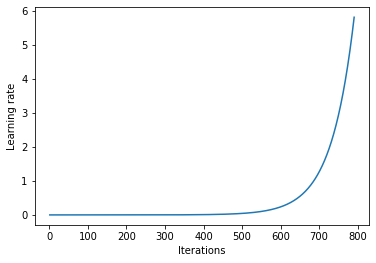

In [23]:
lr_finder.plot_lr()

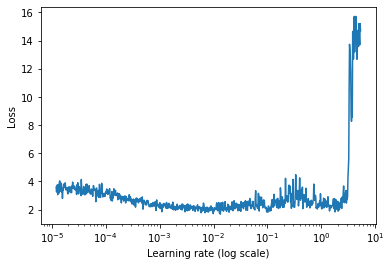

In [24]:
lr_finder.plot()


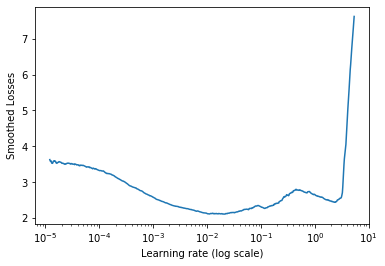

In [25]:
lr_finder.plot_smoothed_loss()


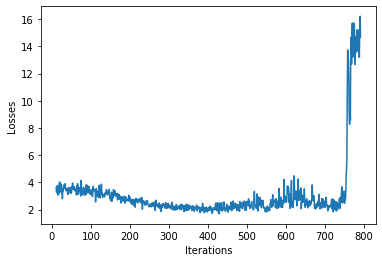

In [26]:
lr_finder.plot_loss()


## Lr finder found that optimum lr is 0.012

In [0]:
lr_found = 0.012

In [28]:
model_with_lrfinder = create_base_network()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_1", input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_2", padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_4", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_5", padding="same")`
/usr/local/lib/python3.6/dist-p

In [29]:
model_with_lrfinder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)       

In [0]:
checkpointer = ModelCheckpoint(filepath=best_weights_name,verbose = 0,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(monitor='val_acc',factor=0.8, cooldown=0, patience=5, min_lr=0.5e-9,verbose = 0)
sgd_new = optimizers.SGD(lr=lr_found, decay=0, momentum=0.8, nesterov=False)

In [0]:
model_with_lrfinder.compile(optimizer=sgd_new, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=0, steps_per_epoch=1562, epochs=100)`
  This is separate from the ipykernel package so we can avoid doing imports until


Model took 3104.95 seconds to train


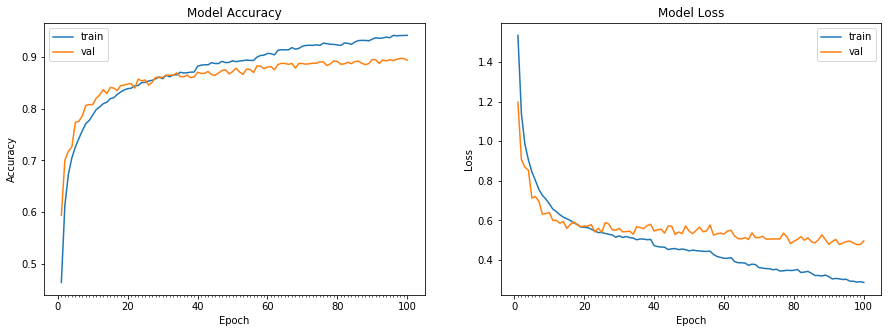

Accuracy on test data is: 89.32


In [32]:
start = time.time()
# Train the model
model_info = model_with_lrfinder.fit_generator(datagen.flow(X_train, Y_train, batch_size = 32),samples_per_epoch = train_features.shape[0], nb_epoch = 100,validation_data = (X_test,Y_test), callbacks=[checkpointer,lr_reducer],verbose=0)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model_with_lrfinder))

In [0]:
model_with_lrfinder.save(save_model_name)

In [0]:
model_loaded=keras.models.load_model(save_model_name)

In [35]:
score = model_loaded.evaluate(X_test, Y_test, batch_size=128)
print(score[1])

10000/10000 [==============================] - 1s 92us/step
0.8932


In [0]:
Y_pred = model_loaded.predict(X_test)


In [0]:
import pandas as pd
def decode(datum):
    return np.argmax(datum)
ytest = []
ypred = []

for i in range(len(Y_test)):
  ytest.append(decode(Y_test[i]))
  ypred.append(decode(Y_pred[i]))

df = pd.DataFrame()
df['Actual'] = ytest
df['Pred']  =  ypred

In [0]:
misclassified = df.index[df['Actual']!=df['Pred']].tolist()
import random
misclassified25 = random.sample(misclassified, 25)

Image index is 9223
actual class automobile
predicted class truck


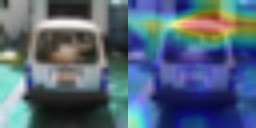

 
Image index is 893
actual class frog
predicted class cat


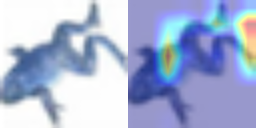

 
Image index is 4051
actual class dog
predicted class cat


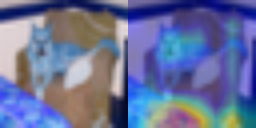

 
Image index is 2486
actual class horse
predicted class deer


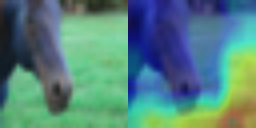

 
Image index is 69
actual class horse
predicted class deer


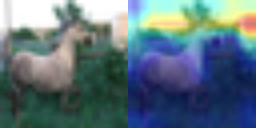

 
Image index is 1905
actual class cat
predicted class frog


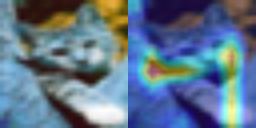

 
Image index is 6901
actual class bird
predicted class truck


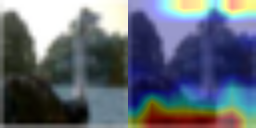

 
Image index is 956
actual class airplane
predicted class bird


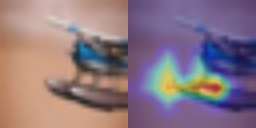

 
Image index is 6653
actual class airplane
predicted class bird


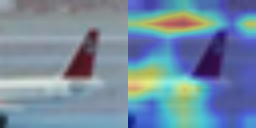

 
Image index is 2005
actual class dog
predicted class cat


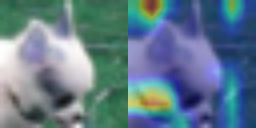

 
Image index is 4590
actual class truck
predicted class bird


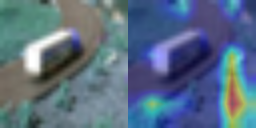

 
Image index is 4784
actual class airplane
predicted class ship


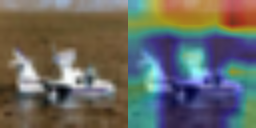

 
Image index is 2172
actual class dog
predicted class deer


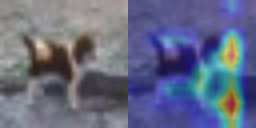

 
Image index is 1227
actual class cat
predicted class dog


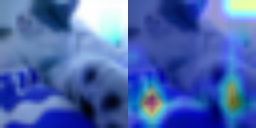

 
Image index is 7598
actual class cat
predicted class horse


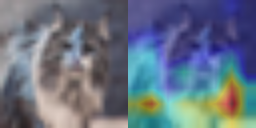

 
Image index is 1355
actual class dog
predicted class cat


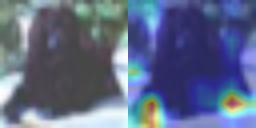

 
Image index is 2642
actual class horse
predicted class bird


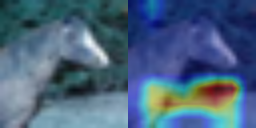

 
Image index is 9801
actual class frog
predicted class bird


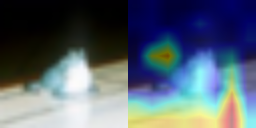

 
Image index is 7924
actual class cat
predicted class dog


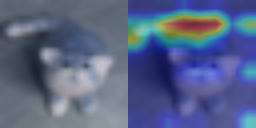

 
Image index is 7843
actual class airplane
predicted class truck


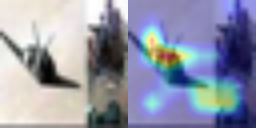

 
Image index is 6627
actual class dog
predicted class cat


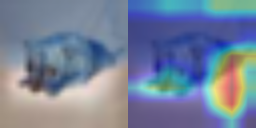

 
Image index is 3056
actual class deer
predicted class dog


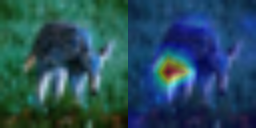

 
Image index is 1178
actual class frog
predicted class bird


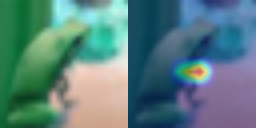

 
Image index is 9704
actual class bird
predicted class cat


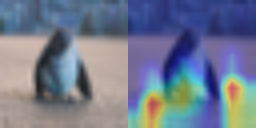

 
Image index is 9641
actual class frog
predicted class cat


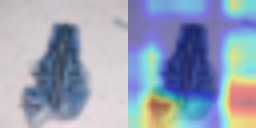

In [39]:
import cv2
from google.colab.patches import cv2_imshow

images = misclassified25

for j in images:
  x = testX[j]
  x = np.expand_dims(x, axis=0)
  preds = model_loaded.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model_loaded.output[:, class_idx]
  last_conv_layer = model_loaded.get_layer("conv2D_8")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model_loaded.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap) 
  img = (testX[j])
  img = cv2.resize(img,(128,128))
  heatmap = cv2.resize(heatmap, (128, 128))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  concatimg = cv2.hconcat([img,superimposed_img])
  print ("Image index is " + str(j))
  print ("actual class " + str(class_names[df['Actual'][j]]))
  print ("predicted class " + str(class_names[df['Pred'][j]]))
  cv2_imshow(concatimg)
  cv2.waitKey(0)
  print (" ")
  j = j + 1
